In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

read data

In [4]:
path = "AirPassengers.csv" #For Alpha Lu
dataset = pd.read_csv(path)
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


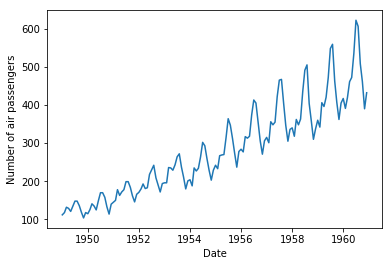

In [5]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

* window size 12 denotes 12 months, giving rolling mean at yearly level

* we now Determine rolling statistics

In [6]:
rolmean = indexedDataset.rolling(window=12).mean() 
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01   126.666667
1950-01-01   126.916667
1950-02-01   127.583333
1950-03-01   128.333333
1950-04-01   128.833333
1950-05-01   129.166667
1950-06-01   130.333333
1950-07-01   132.166667
1950-08-01   134.000000
1950-09-01   135.833333
1950-10-01   137.000000
1950-11-01   137.833333
1950-12-01   139.666667
1951-01-01   142.166667
1951-02-01   144.166667
1951-03-01   147.250000
1951-04-01   149.583333
1951-05-01   153.500000
1951-06-01   155.916667
...                 ...
1958-07-01   376.333333
1958-08-01   379.500000
1958-09-01   379.500000
1958-10-01   380.500000
1958-11-01   380.916667
1958-12-01   381.000000
1959-01-01   382.666667
1959-02-01   384.666667
1959-03-01   388

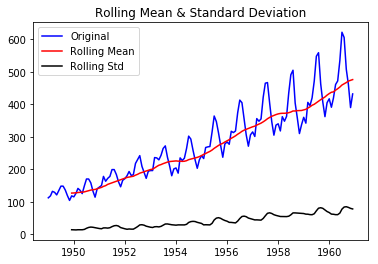

In [7]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.

* Perform Augmented Dickey–Fuller test:

In [10]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


* For a Time series to be stationary, its ADCF test should have:

* p-value to be low (according to the null hypothesis)
* The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

* From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary



## data transformation

There are a couple of ways to achieve stationarity through data transformation like taking  **log10, square, square root, cube, cube root, exponential decay, time shift**  and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.



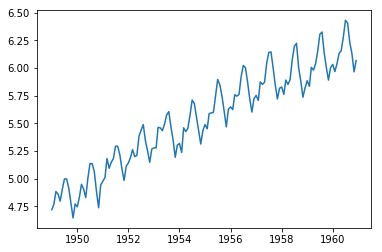

In [11]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

* The below transformation is required to make series stationary

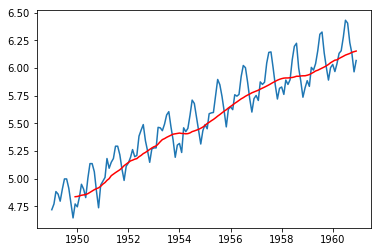

In [13]:

movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:

logscaleL=stationarypart(L1)+trend(LT)
 
movingavgoflogscaleA=stationarypart(A1)+trend(AT)
 
resultseriesR=L−A=(L1+LT)−(A1+AT)=(L1−A1)+(LT−AT)
 

Since, L & A are series & it moving avg, their trend will be more or less same, Hence
LT-AT nearly equals to 0

Thus trend component will be almost removed. And we have,

R=L1−A1
 , our final non-trend curve

In [14]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [15]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

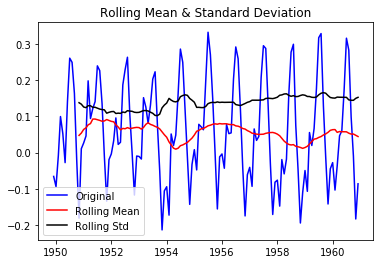

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [16]:
test_stationarity(datasetLogScaleMinusMovingAverage)


From above graph, we observe that our intuition that "subtracting two related series having similar trend components will make the result stationary" is true. We find that:

p-value has reduced from 0.99 to 0.022.
The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. Thus, from above 2 points, we can say that our given series is stationary.
But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.
For further info, refer to my answer 12 at the top of the notebook on it.



## Exponential Decay Transformation

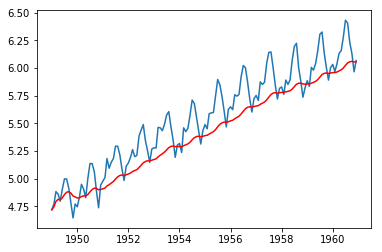

In [17]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar. But, in statistics, inferences cannot be drawn simply by looking at the curves. Hence, we perform the ADCF test again on the decay series below.

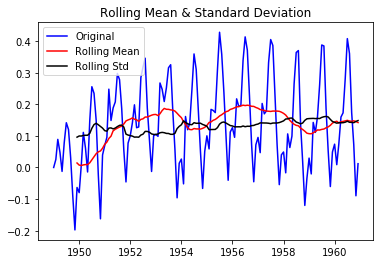

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [18]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.
Also,

p-value has decreased from 0.022 to 0.005.
Test Statistic value is very much closer to the Critical values.
Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.
But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:

Given a set of observation on the time series:
x0,x1,x2,x3,....xn
 

The shifted values will be:
null,x0,x1,x2,....xn
  <---- basically all xi's shifted by 1 pos to right

Thus, the time series with time shifted values are:
null,(x1−x0),(x2−x1),(x3−x2),(x4−x3),....(xn−xn−1)
 

## Timeshift transformation

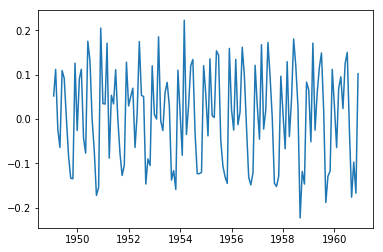

In [19]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

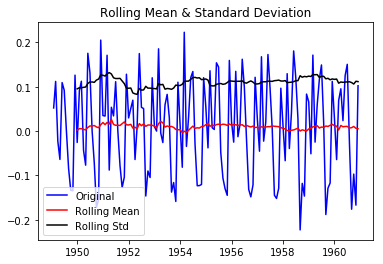

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [21]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:

p-value of 0.07 is not as good as 0.005 of exponential decay.
Test Statistic value not as close to the critical values as that for exponential decay.
We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


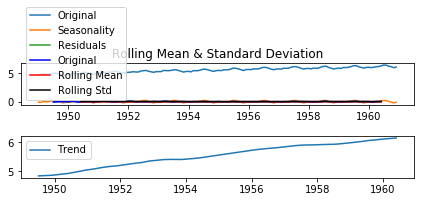

Results of Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [23]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

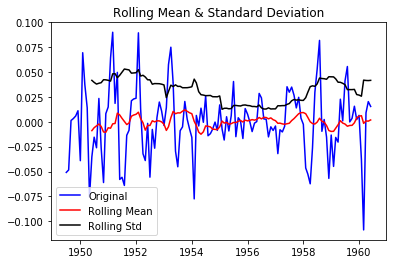

Results of Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [24]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

## plotting ACF PACF

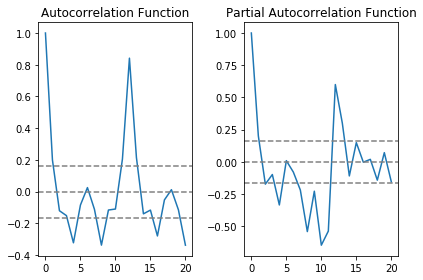

In [25]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

## Building Models

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted a

Plotting AR model


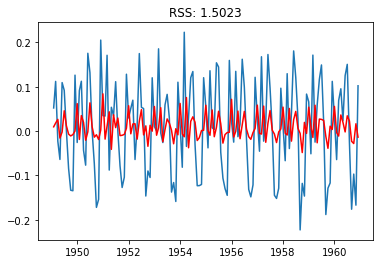

In [26]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR model')

Plotting MA model


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


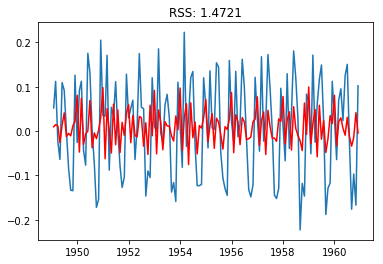

In [27]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA model')

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


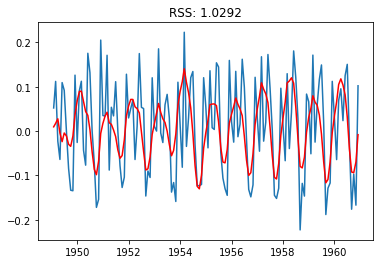

In [28]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case to 1.0292, indicating ARIMA to be better than its individual component models.

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.

In [29]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [30]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
1949-07-01    0.021985
1949-08-01    0.011007
1949-09-01   -0.018922
1949-10-01   -0.053389
1949-11-01   -0.064668
1949-12-01   -0.027456
1950-01-01    0.040679
1950-02-01    0.130113
1950-03-01    0.220142
1950-04-01    0.286294
1950-05-01    0.330347
1950-06-01    0.365814
1950-07-01    0.368914
1950-08-01    0.321787
1950-09-01    0.235434
1950-10-01    0.136969
1950-11-01    0.069123
1950-12-01    0.063895
1951-01-01    0.081280
1951-02-01    0.115295
1951-03-01    0.157857
1951-04-01    0.176605
1951-05-01    0.191865
1951-06-01    0.194354
1951-07-01    0.181946
                ...   
1958-07-01    1.166554
1958-08-01    1.150089
1958-09-01    1.070247
1958-10-01    0.987104
1958-11-01    0.928235
1958-12-01    0.925572
1959-01-01    0.956771
1959-02-01    1.008216
1959-03-01    1.088022
1959-04-01    1.153356
1959-05-01    1.211546
1959-06-01    1.247620
1959-

In [31]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

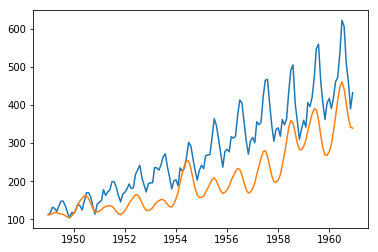

In [32]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

In [33]:
indexedDataset_logScale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
1949-06-01,4.905275
1949-07-01,4.997212
1949-08-01,4.997212
1949-09-01,4.912655


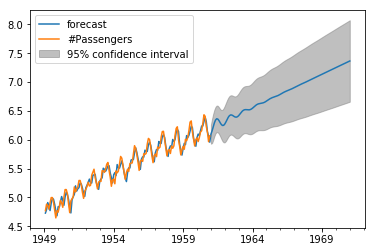

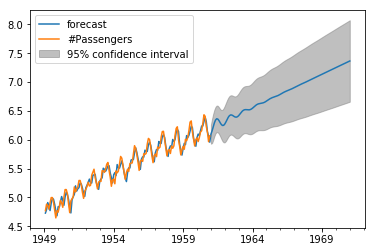

In [34]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) 
#x=results_ARIMA.forecast(steps=120)

Again, thanks kaggle https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima for guiding 